# Step-by-step MRI reconstruction using learned dictionaries

## Introduction

This code accompanies the educational talk given in the 2020 ISMRM Virtual Meeting:  

Hands-On: Image Reconstruction  
https://www.ismrm.org/20/program_files/STh08.htm

A live Q&A is planned on Thursday, 13 August 2020, 15:50 - 16:35 UTC. Change to local time-zone here:  
https://www.timeanddate.com/worldclock/converter.html?iso=20200813T155000&p1=1440&p2=195&p3=240&p4=24

---
The purpose of this code is to introduce and demonstrate dictionary learning for MRI. Users will be able to replicate some of the results in the ISMRM presentation, as well as change the various parameters and see their effect.

The code uses [SigPy](https://sigpy.readthedocs.io/en/latest/) developed by by Frank Ong et al. However, not all the demo code supports running on GPU, and was not implemented with  fast, vectorized code. Therefore, there is room to greatly reduce the run-time of these algorithms.
___


## Getting started
Before starting, install the required Python packages

In [1]:
! pip install -r requirements.txt

Obtaining sigpy from git+git@github.com:mikgroup/sigpy@0918134e658b065c5d9a242b0a3986b389bf0a34#egg=sigpy (from -r requirements.txt (line 2))
  DEPRECATION: This form of VCS requirement is being deprecated: git+git@github.com:mikgroup/sigpy@0918134e658b065c5d9a242b0a3986b389bf0a34#egg=sigpy. pip 21.0 will remove support for this functionality. A possible replacement is git+https://git@example.com/..., git+ssh://git@example.com/..., or the insecure git+git://git@example.com/.... You can find discussion regarding this at https://github.com/pypa/pip/issues/7554.
  Cloning git@github.com:mikgroup/sigpy (to revision 0918134e658b065c5d9a242b0a3986b389bf0a34) to ./src/sigpy
  Running command git clone -q git@github.com:mikgroup/sigpy /home/jon/projects/dictionary_learning_ismrm_2020/src/sigpy
  Running command git checkout -q 0918134e658b065c5d9a242b0a3986b389bf0a34
  Attempting uninstall: sigpy
    Found existing installation: sigpy 0.1.17
    Uninstalling sigpy-0.1.17:
      Successfully un

---

Package imports. Of note, we will use `sigpy` to implement dictionary learning routines and `sigpy.plot` to display multi-dimensional images. We use `epgcpmg` to simulate CPMG echo trains using the Extended Phase Graph Algorithm. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocessing import Pool

import sigpy as sp
import sigpy.plot as pl
import epgcpmg as epmg

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib notebook


Set some machine parameters

In [43]:
params = {
    'n_proc': 40, # number of cpu cores to use, when possible
    'figsize': (8, 2), # default figure size
    'device': sp.cpu_device, # which device to use (not all is supported on GPU)
    'mode': 'omp'
}

## Formulation
In dictionary learning, our training set $\mathbf X \in \mathbb{C}^{N \times L}$ ($L$ training examples, each of length-$N$) is represented as a sparse linear combination of atoms from a dictionary $\mathbf D \in \mathbb{C}^{N \times K}$ with sparse codes $\mathbf A \in \mathbb{C}^{K\times L}$:
$$ \mathbf X = \mathbf D \mathbf A $$ 
where each column of $\mathbf D$ is a dictionary atom, and each column of $\mathbf A$ is a sparse code for the corresponding column in $\mathbf X$.

It is common to enforce a bounded l2-norm on the dictionary atoms to avoid scaling ambiguities. To enforce sparisty, we will explore two approaches:
1. Orthogonal Matching Pursuit, a greedy method for building a $K$-sparse vector to approximately solve
\begin{align}
\min_{\mathbf{A},\mathbf{D}} \frac{1}{2}||\mathbf{X} - \mathbf{DA} ||_2^2 \quad \text{subject to }& \\
||\alpha_l|| &\leq K, \quad l=1,...,L \\
||d_p|| & \leq 1, \quad p=1,...,P
\end{align}
1. Basis Pursuit, an l1-relaxation method for promoting sparsity:
\begin{align*}
\min_{\mathbf{A},\mathbf{D}} \frac{1}{2}||\mathbf{X} - \mathbf{DA} ||_2^2 + \lambda || \mathbf A || _1 \quad  \text{subject to }& 
||d_p|| \leq 1, \quad p=1,...,P
\end{align*}

In both cases, we can use alternating minimization to jointly solve for $\mathbf A$ and $\mathbf D$.


### Sparse Decomposition
In the sparse decomposition stage, the dictionary is fixed and we update the sparse code (coefficients) of each column of $A$. Our sparse code will support both OMP and L1-minimization.

### Orthogonal Matching Pursuit
Our Orthogonal Matching Pursuit (OMP) algorithm is based on the folllowing paper:

[TODO] OMP Paper

It approximately solves (1) above by successively building a vector until it has $K$ non-zeros. 

In [148]:
def omp_single(yi, D, num_nonzero_coeffs=3, use_sigpy=False, device=None):
    r"""Orthogonal Matching Pursuit (OMP) for a data point.
    Args:
        yi: [N, 1] data point
        D: [N, P] dictionary
        num_nonzero_coeffs: K in notation above
        device: SigPy device (cpu or gpu)
    Notes:
        Not fully tested on GPU
        Not vectorized for speed
    """
    
    device = sp.get_device(yi)
    xp = sp.Device(device).xp
        
    resid = yi
    idxs = []
    for k in range(num_nonzero_coeffs):
        z = abs(xp.conj(D.T).dot(resid))
        ii = int(xp.argmax(z))
        idxs = idxs + [ii]
        Dsub = D[:, idxs]
        if use_sigpy:
            A_D = sp.linop.MatMul([len(idxs),1], Lsub)
            vals = sp.app.LinearLeastSquares(A_D, yi, show_pbar=False).run().ravel()
        else:
            if device is None or device == sp.cpu_device:
                rcond = None
            else:
                rcond = -1
            vals = xp.linalg.lstsq(Dsub, yi, rcond=rcond)[0]
        resid = yi - Dsub.dot(vals)
    return idxs, vals.ravel()


class OMP(sp.alg.Alg):
    r"""Orthogonal Matching Pursuit (OMP) algorithm for a batch of data.
    Args:
        y: [N, L] data
        D: [N, P] dictionary
        num_nonzero_coeffs: K in notation above
        DC: whether to include a DC dictionary element
    """

    def __init__(
            self,
            y,
            D,
            num_nonzero_coeffs,
            device=sp.cpu_device,
            DC=False,
            **kwargs):
        
        
        self.max_iter = y.shape[1]
            
        self.y = sp.to_device(y, device)
        self.D = sp.to_device(D, device)
        self.num_filters = self.D.shape[-1]
        self.num_nonzero_coeffs = num_nonzero_coeffs
        self.device = sp.Device(device)
        self.DC = DC
        
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.A_shape = (self.num_filters, self.num_data)

        xp = self.device.xp
        self.A = xp.zeros((self.num_filters, self.num_data), dtype=self.y.dtype)
        self.iter = 0
                
        super().__init__(self.max_iter)
        
    def _update(self):

        xp = self.device.xp
        yi = self.y[:, self.iter]
        idxs, vals = omp_single(yi, self.D, self.num_nonzero_coeffs, device=self.device)
        self.A[idxs, self.iter] = vals.ravel()
        
    def _done(self):
        return (self.iter >= self.max_iter)   
    
    
class SparseDecom(sp.app.App):
    r"""Compute the sparse coefficients for a dataset given a fixed dictionary
    Args:
        y: [N, L] data
        D: [N, P] dictionary
        lamda: sparsity level (if mode='omp') or l1-regularization parameter (if mode=l1)
        mode: l1 for l1-regularization or omp for OMP
        DC: whether to include a DC dictionary element
        device: CPU or GPU
    """      
    def __init__(
        self,
        y,
        D,
        lamda=0.005,
        mode='l1',
        DC=False,
        device=sp.cpu_device,
        show_pbar=True,
        leave_pbar=True,
        **kwargs):
        self.y = sp.to_device(y, device)
        self.D = sp.to_device(D, device)
        self.lamda = lamda
        self.device = device
        self.mode = mode
        self.show_pbar = show_pbar
        self.leave_pbar = leave_pbar

        self._get_params()
        
        if self.mode is 'omp':
            self.alg = OMP(self.y, 
                           self.D, 
                           self.lamda, 
                           DC=DC,
                           device=self.device)
        else:
            self.A = sp.linop.MatMul(
                self.A_shape,
                self.D)
            
            if self.mode is 'l1':
                proxg_A = sp.prox.L1Reg(self.A_shape, lamda)
            elif self.mode is 'l0':
                proxg_A = L0Proj(self.A_shape, lamda, 0)

            self.alg = sp.app.LinearLeastSquares(self.A, 
                                                 self.y, 
                                                 proxg=proxg_A, 
                                                 show_pbar=self.show_pbar, 
                                                 **kwargs).alg
         
        super().__init__(self.alg, show_pbar=self.show_pbar, leave_pbar=self.leave_pbar)
        
        self._output = self.__output



    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_data = self.y.shape[-1]
        self.num_filters = self.D.shape[-1]
        self.num_points = self.D.shape[0]

        self.A_shape = (self.num_filters, self.num_data)
        
    def __output(self):
        if self.mode == 'omp':
            return self.alg.A
        else:
            return self.alg.x


def nrmse(x, y):
    xp = sp.get_device(x).xp
    return xp.linalg.norm(x.ravel() - y.ravel()) / xp.linalg.norm(x.ravel())


## Experiment: Denoise randomly generated data fitting the model
We create synthetic data that fits the model with a random dictionary and K-sparse vectors. We add noise and estimate the sparse codes using OMP and L1-minimization

(50, 500) (50, 100) (100, 500)


<IPython.core.display.Javascript object>


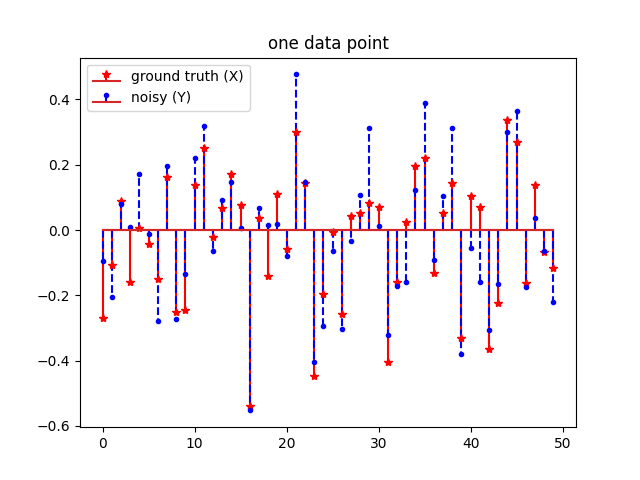

In [196]:
num_data = 500 # L above
num_points = 50 # N above
num_filters = 100 # P above
num_nonzero_coeffs = 5 # K above
l1_lamda = .1 # lambda above


A = np.vstack((np.random.randn(num_nonzero_coeffs, num_data), np.zeros((num_filters - num_nonzero_coeffs, num_data)))).T
A = np.array([np.random.permutation(ai) for ai in A]).T
D = np.random.randn(num_points, num_filters)
D = D / np.linalg.norm(D, axis=0)[None,:]
X = D.dot(A)

stdev = 0.1

Y = X + stdev * np.random.randn(*X.shape)

print(X.shape, D.shape, A.shape)
plt.figure()
plt.stem(X[:,:1], markerfmt='r*', linefmt='r', use_line_collection=True);
plt.stem(Y[:,:1], markerfmt='b.', linefmt='b--', use_line_collection=True);
plt.title('one data point')
plt.legend(('ground truth (X)', 'noisy (Y)'))

In [197]:
with params['device']:
    print('OMP')
    app = SparseDecom(Y, D, num_nonzero_coeffs, mode='omp', max_iter=100, device=params['device'])
    A_hat_omp = app.run()

    print('L1')
    app = SparseDecom(Y, D, l1_lamda, mode='l1', max_iter=100, device=params['device'])
    A_hat_l1 = app.run()
    
A_hat_omp = sp.to_device(A_hat_omp, sp.cpu_device)   
A_hat_l1 = sp.to_device(A_hat_l1, sp.cpu_device)

X_hat_omp = D.dot(A_hat_omp)
X_hat_l1 = D.dot(A_hat_l1)

print('NRMSE between noisy and true data:', nrmse(X, Y))
print('NRMSE between estimate and true data:', nrmse(X, X_hat_omp))

print('NRMSE between estimate and true data:', nrmse(X, X_hat_l1))

OMP



L1



NRMSE between noisy and true data: 0.3140607545609746
NRMSE between estimate and true data: 0.1711025750506503
NRMSE between estimate and true data: 0.1901000825290131


<IPython.core.display.Javascript object>


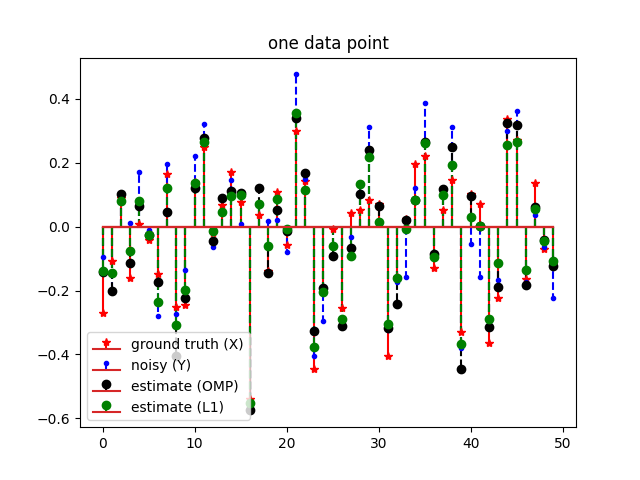

Text(0.5, 1.0, 'one data point')

In [199]:
plt.figure()
plt.stem(X[:,:1], markerfmt='r*', linefmt='r', use_line_collection=True);
plt.stem(Y[:,:1], markerfmt='b.', linefmt='b--', use_line_collection=True);
plt.stem(X_hat_omp[:,:1], markerfmt='ko', linefmt='k--', use_line_collection=True);
plt.stem(X_hat_l1[:,:1], markerfmt='go', linefmt='g--', use_line_collection=True);

plt.legend(('ground truth (X)', 'noisy (Y)', 'estimate (OMP)', 'estimate (L1)'))
plt.title('one data point')



Load relaxation values from brain imaging at 3T, and custom refocusing flip angle array for a variable flip-angle multi-echo spin-echo sequence

<IPython.core.display.Javascript object>


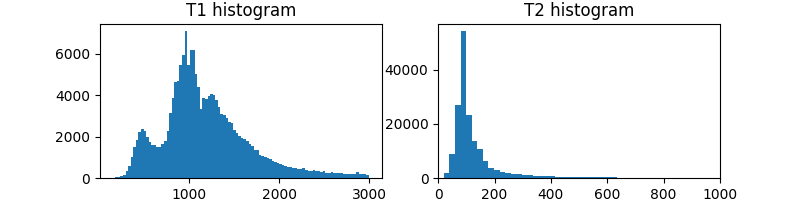

<IPython.core.display.Javascript object>


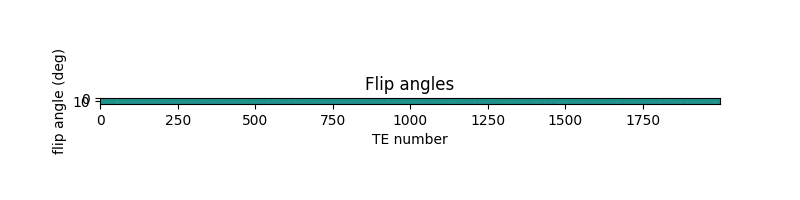

In [8]:
t1_t2_brain = np.load('data/t1t2_brain.npy')
flipangles = np.loadtxt('data/flipangles.txt')

flipangles_rad = flipangles * np.pi / 180
T = len(flipangles)
N_total = t1_t2_brain.shape[0]

plt.figure(figsize=figsize)
plt.subplot(1,2,1)
plt.hist(t1_t2_brain[:,0], 100)
plt.title('T1 histogram')
plt.xlabel('T1 (ms)')

plt.subplot(1,2,2)
plt.hist(t1_t2_brain[:,1], 100)
plt.title('T2 histogram')
plt.xlabel('T2 (ms)')
plt.xlim([0, 1000])

plt.figure(figsize=figsize)
plt.plot(flipangles)
plt.title('Flip angles')
plt.xlabel('TE number')
plt.ylabel('flip angle (deg)');